# Data Grouping

## 📘 Cell 1: Import dan Setup Folder

In [12]:
# 📦 Import library yang dibutuhkan
import os
import pandas as pd

## 📘 Cell 2: Definisikan Folder dan Inisialisasi

In [13]:
# 📁 Path ke folder utama
root_folder = "DataGrouping5"

# 📂 Inisialisasi struktur data untuk semua tipe model
all_data = {
    "ensemble": [],
    "konvensional": [],
    "ann": [],
    "kfold": []
}

## 📘 Cell 3: Membaca Semua CSV dan Normalisasi

In [14]:
# 🔁 Membaca semua file CSV dalam subfolder dan normalisasi kolom
for subdir in os.listdir(root_folder):
    subfolder_path = os.path.join(root_folder, subdir)

    if os.path.isdir(subfolder_path):
        for file in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file)

            if file.endswith(".csv"):
                df = pd.read_csv(file_path)

                # Tambahkan kolom FileName untuk SEMUA file
                df["FileName"] = file

                # --- Untuk file KFold ---
                if "kfold" in file.lower():
                    df_kfold = df[[
                        "Percobaan", "Model",
                        "Accuracy_Test", "Precision_Test", "Recall_Test", "F1-Score_Test",
                        "FileName"
                    ]].copy()

                    df_kfold = df_kfold.rename(columns={
                        "Accuracy_Test": "Accuracy",
                        "Precision_Test": "Precision",
                        "Recall_Test": "Recall",
                        "F1-Score_Test": "F1-Score"
                    })

                    df_kfold["Tipe"] = "kfold"
                    df_kfold["Sumber"] = subdir
                    all_data["kfold"].append(df_kfold)

                # --- Untuk file ensemble ---
                elif "ensemble" in file.lower():
                    df["Tipe"] = "ensemble"
                    df["Sumber"] = subdir
                    all_data["ensemble"].append(df)

                # --- Untuk file ann ---
                elif "ann" in file.lower():
                    df["Tipe"] = "ann"
                    df["Sumber"] = subdir
                    all_data["ann"].append(df)

                # --- Untuk file model konvensional ---
                elif "konvensional" in file.lower():
                    df["Tipe"] = "konvensional"
                    df["Sumber"] = subdir
                    all_data["konvensional"].append(df)

## 📘 Cell 4: Gabungkan Semua Data

In [15]:
# 📊 Gabungkan semua data menjadi satu DataFrame
df_all = pd.concat(
    all_data["ensemble"] +
    all_data["konvensional"] +
    all_data["ann"] +
    all_data["kfold"],
    ignore_index=True
)

# Pastikan kolom evaluasi numerik
for metric in ["Accuracy", "Precision", "Recall", "F1-Score"]:
    df_all[metric] = pd.to_numeric(df_all[metric], errors="coerce")

## 📘 Cell 5: Fungsi untuk Ambil Model Terbaik/Terburuk

In [16]:
# # 🎯 Fungsi untuk mengambil n model terbaik atau terburuk berdasarkan F1-Score
# def get_top_bottom(df, tipe=None, top_n=10, worst=False):
#     temp = df.copy()
#     if tipe:
#         temp = temp[temp["Tipe"] == tipe]
#     # 🔑 Urutan sorting multi-kriteria
#     temp = temp.sort_values(
#         ["F1-Score", "Precision", "Recall", "Accuracy"],
#         ascending=[worst, worst, worst, worst]
#     )
#     return temp.head(top_n)

# 🎯 Fungsi untuk mengambil n model terbaik atau terburuk berdasarkan F1-Score
def get_top_bottom(df, tipe=None, top_n=10, worst=False):
    temp = df.copy()
    if tipe:
        temp = temp[temp["Tipe"] == tipe]
    # 🔑 Urutan sorting multi-kriteria
    temp = temp.sort_values(
        ["F1-Score", "Recall", "Precision", "Accuracy"],
        ascending=[worst, worst, worst, worst]
    )
    return temp.head(top_n)


## 📘 Cell 6: Subset Kategori Tambahan

In [17]:
# --- KFold khusus (results_kfold.csv di folder tertentu)
kfold_folders = ["DataSmote", "DataImbalance", "DataOverSamplingRandom", "DataUndersampling"]
df_kfold_special = df_all[
    (df_all["Tipe"] == "kfold") &
    (df_all["Sumber"].isin(kfold_folders)) &
    (df_all["FileName"].str.lower().eq("results_kfold.csv"))
]

In [18]:
# --- Balance (3 folder)
balance_folders = ["DataOverSamplingRandom", "DataSmote", "DataUndersampling"]
df_balance = df_all[df_all["Sumber"].isin(balance_folders)]

In [19]:
# --- PCA (cari kata 'pca' di kolom Percobaan / percobaan)
col_percobaan = [c for c in df_all.columns if c.lower() == "percobaan"]
if col_percobaan:
    pca_col = col_percobaan[0]
    df_pca = df_all[df_all[pca_col].str.lower().str.contains("pca", na=False)]
else:
    df_pca = pd.DataFrame()

In [20]:
# ✅ Normalisasi (normalisasi, normalization, atau pca)
if col_percobaan:
    norm_keywords = r"(normalisasi|normalization|pca)"
    df_norm = df_all[df_all[pca_col].str.lower().str.contains(norm_keywords, na=False)]
else:
    df_norm = pd.DataFrame()

C:\Users\Ryan\AppData\Local\Temp\ipykernel_28840\3703453277.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_norm = df_all[df_all[pca_col].str.lower().str.contains(norm_keywords, na=False)]


## 📘 Cell 7: Ekstrak Data Terbaik & Terburuk

In [21]:
# 🏆 Ekstrak hasil terbaik & terburuk sesuai task
top_20_models = get_top_bottom(df_all, top_n=20)
top_10_ensemble = get_top_bottom(df_all, tipe="ensemble", top_n=10)
top_10_ann = get_top_bottom(df_all, tipe="ann", top_n=10)
bottom_10_ann = get_top_bottom(df_all, tipe="ann", top_n=10, worst=True)   # ✅ Tambahan ANN Terburuk
bottom_20_models = get_top_bottom(df_all, top_n=20, worst=True)
bottom_10_ensemble = get_top_bottom(df_all, tipe="ensemble", top_n=10, worst=True)

# ✅ Tambahan baru
top_10_kfold_special = get_top_bottom(df_kfold_special, top_n=10)
bottom_10_kfold_special = get_top_bottom(df_kfold_special, top_n=10, worst=True)

top_10_balance = get_top_bottom(df_balance, top_n=10)
bottom_10_balance = get_top_bottom(df_balance, top_n=10, worst=True)

top_10_pca = get_top_bottom(df_pca, top_n=10)
bottom_10_pca = get_top_bottom(df_pca, top_n=10, worst=True)

top_10_norm = get_top_bottom(df_norm, top_n=10)           # ✅ Normalisasi Terbaik
bottom_10_norm = get_top_bottom(df_norm, top_n=10, worst=True)  # ✅ Normalisasi Terburuk

# Filter data tanpa KFold
df_no_kfold = df_all[df_all["Tipe"] != "kfold"]

# Ambil 20 terbaik dan terburuk tanpa KFold
top_20_no_kfold = get_top_bottom(df_no_kfold, top_n=20)
bottom_20_no_kfold = get_top_bottom(df_no_kfold, top_n=20, worst=True)

## 📘 Cell 8: Simpan ke Excel

In [22]:
# 💾 Simpan semua hasil ke file Excel
output_dir = "ResultGrouping"
os.makedirs(output_dir, exist_ok=True)  # Membuat folder jika belum ada

output_file_full = os.path.join(output_dir, "hasil_klasifikasi_model5_Ryan.xlsx")

with pd.ExcelWriter(output_file_full, engine='xlsxwriter') as writer:
    # sheet lama
    top_20_models.to_excel(writer, sheet_name="20_Model_Terbaik", index=False)
    bottom_20_models.to_excel(writer, sheet_name="20_Model_Terburuk", index=False)
    top_10_ensemble.to_excel(writer, sheet_name="10_Ensemble_Terbaik", index=False)
    bottom_10_ensemble.to_excel(writer, sheet_name="10_Ensemble_Terburuk", index=False)
    top_10_ann.to_excel(writer, sheet_name="10_ANN_Terbaik", index=False)
    bottom_10_ann.to_excel(writer, sheet_name="10_ANN_Terburuk", index=False)
    # sheet tambahan
    top_10_kfold_special.to_excel(writer, sheet_name="10_KFold_Terbaik", index=False)
    bottom_10_kfold_special.to_excel(writer, sheet_name="10_KFold_Terburuk", index=False)
    top_10_balance.to_excel(writer, sheet_name="10_Balance_Terbaik", index=False)
    bottom_10_balance.to_excel(writer, sheet_name="10_Balance_Terburuk", index=False)
    top_10_pca.to_excel(writer, sheet_name="10_PCA_Terbaik", index=False)
    bottom_10_pca.to_excel(writer, sheet_name="10_PCA_Terburuk", index=False)
    top_10_norm.to_excel(writer, sheet_name="10_Normalisasi_Terbaik", index=False)  # ✅ Normalisasi Terbaik
    bottom_10_norm.to_excel(writer, sheet_name="10_Normalisasi_Terburuk", index=False)  # ✅ Normalisasi Terburuk
    # ✅ Sheet baru: tanpa KFold
    top_20_no_kfold.to_excel(writer, sheet_name="20_Terbaik_No_KFold", index=False)
    bottom_20_no_kfold.to_excel(writer, sheet_name="20_Terburuk_No_KFold", index=False)

    workbook = writer.book
    format_full = workbook.add_format({'num_format': '0.000000000000000'})
    for sheetname in writer.sheets:
        worksheet = writer.sheets[sheetname]
        worksheet.set_column('C:H', 25, format_full)  # kolom metrik & FileName

print(f"File presisi penuh tersimpan: {output_file_full}")

File presisi penuh tersimpan: ResultGrouping\hasil_klasifikasi_model5_Ryan.xlsx


## 📘 Cell 9: Simpan Excel – Ringkas 3 Desimal

In [23]:
output_dir = "ResultGrouping"
os.makedirs(output_dir, exist_ok=True)  # Membuat folder jika belum ada

output_file_round = os.path.join(output_dir, "hasil_klasifikasi_model_ringkas5_Ryan.xlsx")

def round_df(df):
    df_rounded = df.copy()
    for metric in ["Accuracy", "Precision", "Recall", "F1-Score"]:
        if metric in df_rounded.columns:
            df_rounded[metric] = df_rounded[metric].round(3)
    return df_rounded

with pd.ExcelWriter(output_file_round, engine="xlsxwriter") as writer:
    # sheet lama
    round_df(top_20_models).to_excel(writer, sheet_name="20_Model_Terbaik", index=False)
    round_df(bottom_20_models).to_excel(writer, sheet_name="20_Model_Terburuk", index=False)
    round_df(top_10_ensemble).to_excel(writer, sheet_name="10_Ensemble_Terbaik", index=False)
    round_df(bottom_10_ensemble).to_excel(writer, sheet_name="10_Ensemble_Terburuk", index=False)
    round_df(top_10_ann).to_excel(writer, sheet_name="10_ANN_Terbaik", index=False)
    round_df(bottom_10_ann).to_excel(writer, sheet_name="10_ANN_Terburuk", index=False)
    # sheet tambahan
    round_df(top_10_kfold_special).to_excel(writer, sheet_name="10_KFold_Terbaik", index=False)
    round_df(bottom_10_kfold_special).to_excel(writer, sheet_name="10_KFold_Terburuk", index=False)
    round_df(top_10_balance).to_excel(writer, sheet_name="10_Balance_Terbaik", index=False)
    round_df(bottom_10_balance).to_excel(writer, sheet_name="10_Balance_Terburuk", index=False)
    round_df(top_10_pca).to_excel(writer, sheet_name="10_PCA_Terbaik", index=False)
    round_df(bottom_10_pca).to_excel(writer, sheet_name="10_PCA_Terburuk", index=False)
    round_df(top_10_norm).to_excel(writer, sheet_name="10_Normalisasi_Terbaik", index=False)  # ✅ Normalisasi Terbaik
    round_df(bottom_10_norm).to_excel(writer, sheet_name="10_Normalisasi_Terburuk", index=False)  # ✅ Normalisasi Terburuk
    # ✅ Sheet baru: tanpa KFold
    round_df(top_20_no_kfold).to_excel(writer, sheet_name="20_Terbaik_No_KFold", index=False)
    round_df(bottom_20_no_kfold).to_excel(writer, sheet_name="20_Terburuk_No_KFold", index=False)
    
    workbook = writer.book
    format_3 = workbook.add_format({'num_format': '0.000'})
    for sheetname in writer.sheets:
        worksheet = writer.sheets[sheetname]
        worksheet.set_column('C:H', 25, format_3)

print(f"✅ Disimpan versi ringkas ke: {output_file_round}")

✅ Disimpan versi ringkas ke: ResultGrouping\hasil_klasifikasi_model_ringkas5_Ryan.xlsx


C:\Users\Ryan\AppData\Local\Temp\ipykernel_28840\3284191960.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="F1-Score", y="Label", data=df_plot, palette=color)
C:\Users\Ryan\AppData\Local\Temp\ipykernel_28840\3284191960.py:51: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


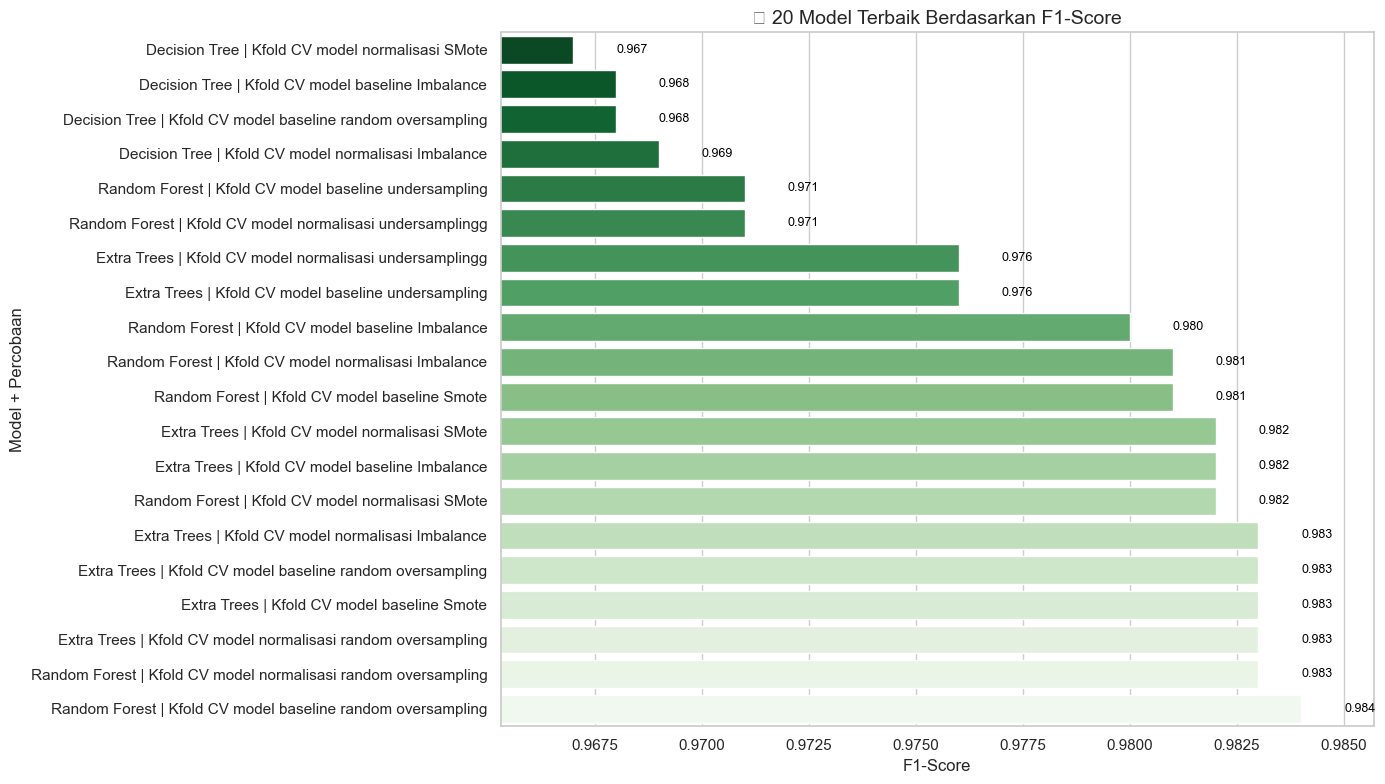

C:\Users\Ryan\AppData\Local\Temp\ipykernel_28840\3284191960.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="F1-Score", y="Label", data=df_plot, palette=color)
C:\Users\Ryan\AppData\Local\Temp\ipykernel_28840\3284191960.py:51: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


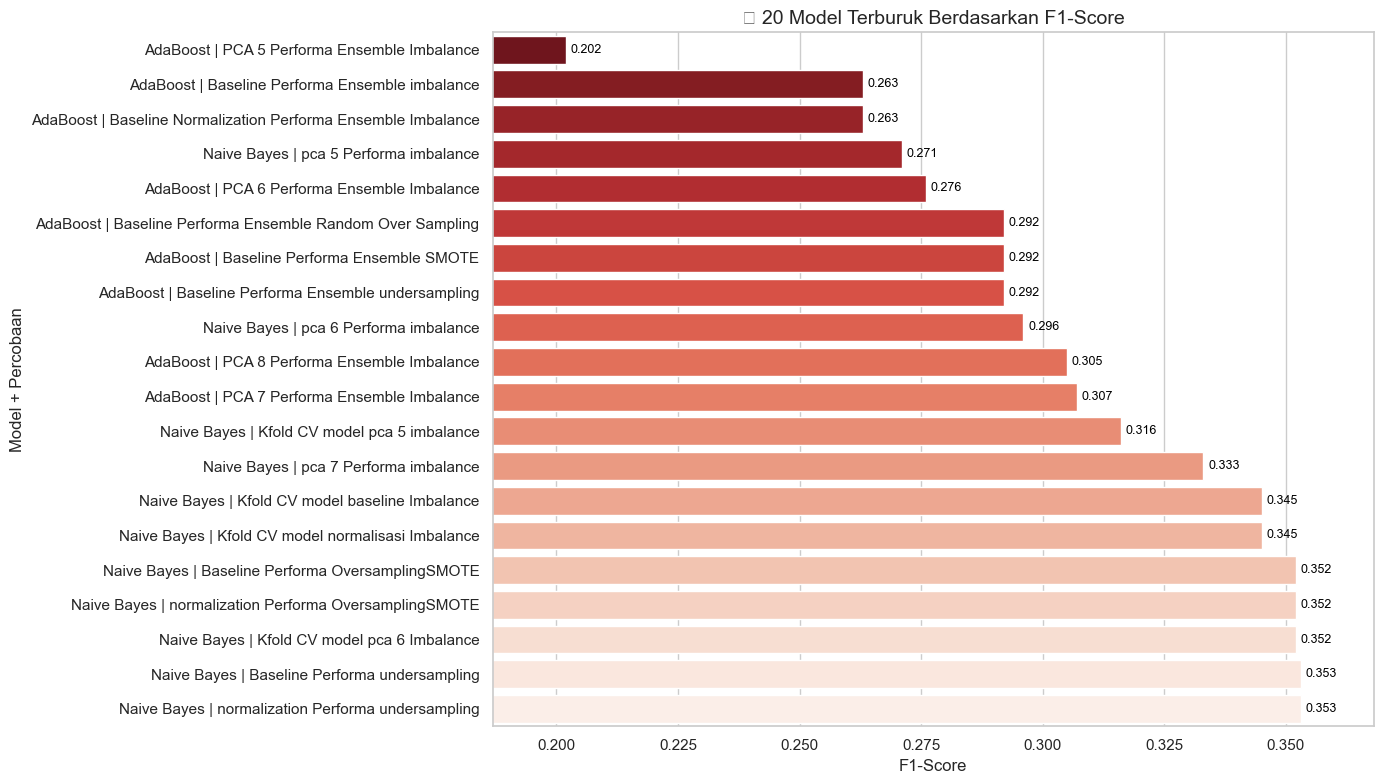

C:\Users\Ryan\AppData\Local\Temp\ipykernel_28840\3284191960.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="F1-Score", y="Label", data=df_plot, palette=color)
C:\Users\Ryan\AppData\Local\Temp\ipykernel_28840\3284191960.py:51: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


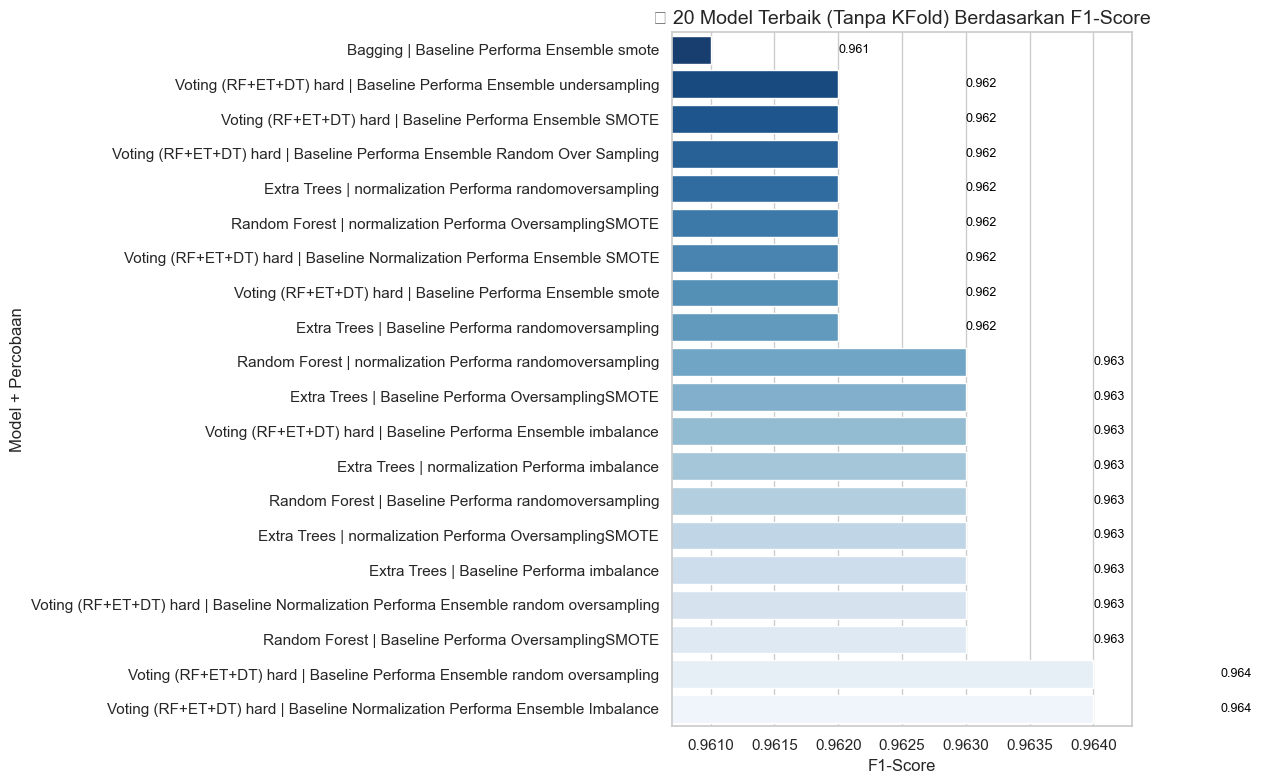

C:\Users\Ryan\AppData\Local\Temp\ipykernel_28840\3284191960.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="F1-Score", y="Label", data=df_plot, palette=color)
C:\Users\Ryan\AppData\Local\Temp\ipykernel_28840\3284191960.py:51: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


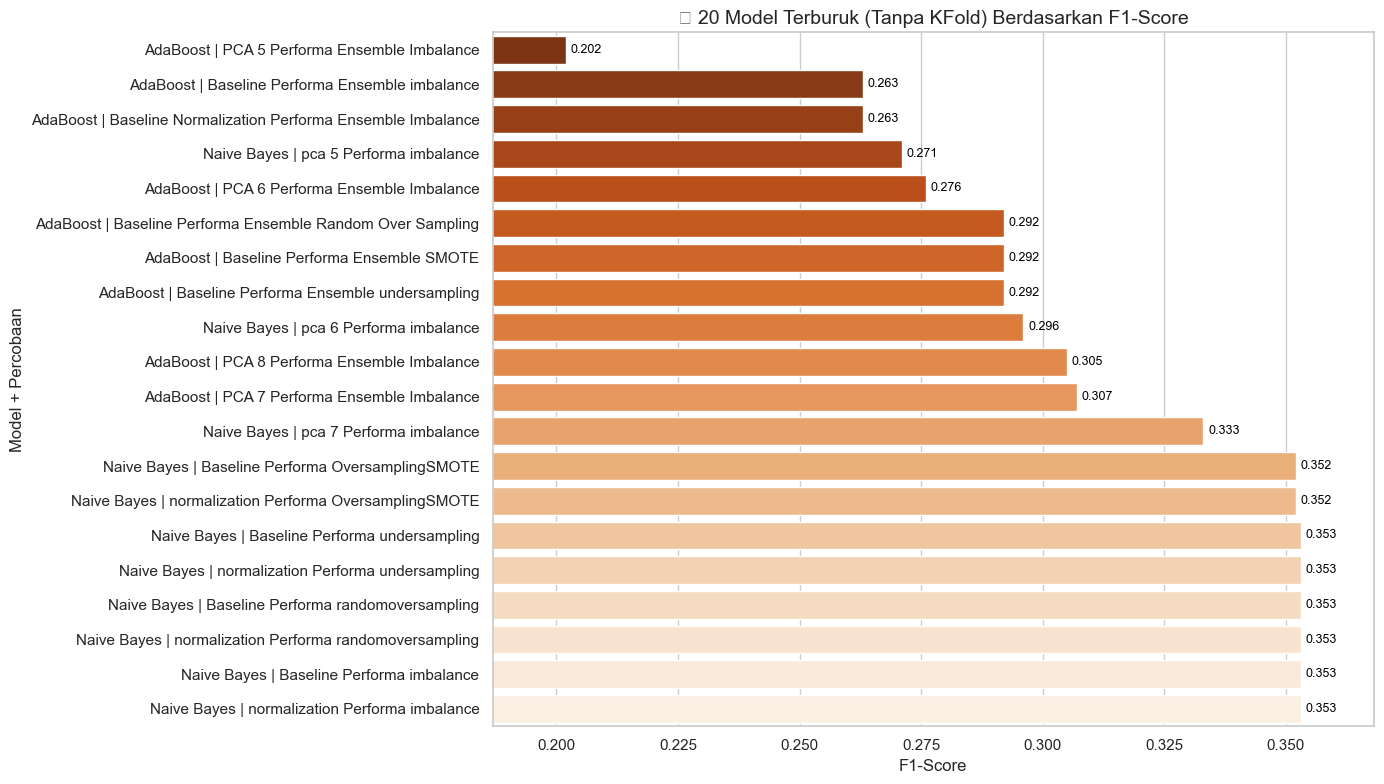

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# 📂 Ganti path jika ingin baca versi presisi penuh
excel_path = os.path.join("ResultGrouping", "hasil_klasifikasi_model_ringkas5_Ryan.xlsx")

# 📥 Baca sheet
df_top20 = pd.read_excel(excel_path, sheet_name="20_Model_Terbaik")
df_bottom20 = pd.read_excel(excel_path, sheet_name="20_Model_Terburuk")

# 📥 Baca sheet tanpa KFold
df_top20_no_kfold = pd.read_excel(excel_path, sheet_name="20_Terbaik_No_KFold")
df_bottom20_no_kfold = pd.read_excel(excel_path, sheet_name="20_Terburuk_No_KFold")

# 🌟 Setup tampilan grafik
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

# 🎨 Fungsi visualisasi yang stabil tanpa 'FileName'
def plot_f1_scores(df, title, color):
    df_plot = df.copy()
    
    # Gunakan kombinasi kolom yang tersedia
    if "Percobaan" in df_plot.columns and "Model" in df_plot.columns:
        df_plot["Label"] = df_plot["Model"].astype(str) + " | " + df_plot["Percobaan"].astype(str)
    else:
        df_plot["Label"] = df_plot["Model"].astype(str)
    
    df_plot = df_plot.sort_values("F1-Score", ascending=True)

    min_score = df_plot["F1-Score"].min()
    max_score = df_plot["F1-Score"].max()
    
    margin = (max_score - min_score) * 0.1
    x_min = max(0, min_score - margin)
    x_max = min(1.0, max_score + margin)
    
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x="F1-Score", y="Label", data=df_plot, palette=color)
    plt.title(title, fontsize=14)
    plt.xlabel("F1-Score")
    plt.ylabel("Model + Percobaan")
    plt.xlim(x_min, x_max)

    # Tambahkan label nilai F1 di ujung bar
    for i, v in enumerate(df_plot["F1-Score"]):
        ax.text(v + 0.001, i, f"{v:.3f}", color='black', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

# 🔝 20 Terbaik
plot_f1_scores(df_top20, "📈 20 Model Terbaik Berdasarkan F1-Score", "Greens_r")

# 🔻 20 Terburuk
plot_f1_scores(df_bottom20, "📉 20 Model Terburuk Berdasarkan F1-Score", "Reds_r")

# 🔝 20 Terbaik Tanpa KFold
plot_f1_scores(df_top20_no_kfold, "📈 20 Model Terbaik (Tanpa KFold) Berdasarkan F1-Score", "Blues_r")

# 🔻 20 Terburuk Tanpa KFold
plot_f1_scores(df_bottom20_no_kfold, "📉 20 Model Terburuk (Tanpa KFold) Berdasarkan F1-Score", "Oranges_r")